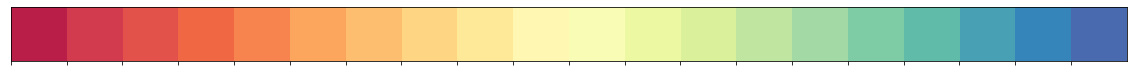

In [2]:
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns
from matplotlib import pyplot as plt
import re
from matplotlib.ticker import MaxNLocator


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

pal = sns.color_palette("Spectral", 20)
customPalette = pal.as_hex()
sns.set_palette(customPalette)
sns.palplot(customPalette)

# Archaeal clusters:

Import annotation:

In [2]:
db = 'kegg'
### Loop the data lines
with open("/work/projects/ecosystem_biology/archaea/coevolution/analysis/mantis/archaea/archaea_annot_"+db+".tsv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
df = pd.read_csv('/work/projects/ecosystem_biology/archaea/coevolution/analysis/mantis/archaea/archaea_annot_'+db+'.tsv', delimiter="\t", names=column_names)
df.dropna(axis=1, how='all', inplace=True)
df.columns=['protein', 'id', 'description']
annot_kegg = df

In [4]:
df = pd.read_csv('/work/projects/ecosystem_biology/archaea/coevolution/analysis/unique_gut_proteins.csv', index_col=False)[['protein', 'cluster']]
df.head()

protein  cluster
0   GUT_GENOME105707.fasta_539   120470
1  GUT_GENOME265514.fasta_1178   120470
2    GUT_GENOME105979.fasta_65   120470
3   GUT_GENOME118556.fasta_882   120470
4   GUT_GENOME118930.fasta_541   120470

In [1]:
original_counts = df.groupby('cluster', as_index=False).agg('count').sort_values('protein', ascending=False)
original_counts[original_counts['protein']=>2].shape[0]

SyntaxError: invalid syntax (110507776.py, line 2)

total # of clusters:

In [5]:
df.cluster.nunique()

233135

In [34]:
annot_clusters_outer = df.merge(annot_kegg, on='protein', how='outer').drop_duplicates()
annot_clusters_outer.head()

annot_clusters_inner = df.merge(annot_kegg, on='protein', how='inner').drop_duplicates()
annot_clusters_inner.head()

protein  cluster      id                  description
0   GUT_GENOME105707.fasta_539   120470  K08094  6-phospho-3-hexuloisomerase
1  GUT_GENOME265514.fasta_1178   120470  K08094  6-phospho-3-hexuloisomerase
2    GUT_GENOME105979.fasta_65   120470  K08094  6-phospho-3-hexuloisomerase
3   GUT_GENOME118556.fasta_882   120470  K08094  6-phospho-3-hexuloisomerase
4   GUT_GENOME118930.fasta_541   120470  K08094  6-phospho-3-hexuloisomerase

calculate how many proteins are **not** annotaed in each cluster:

In [41]:
annot_clusters_counts_nans = annot_clusters_outer\
.groupby(['cluster'], as_index=False)\
.agg({'id': lambda x: x.isnull().sum()})\
.rename(columns={'id':'count'})\
.sort_values('count', ascending=False)

annot_clusters_counts_nans.head()

cluster  count
140118  150933.0    813
2021      2239.0    813
8025      8984.0    800
152614  163959.0    776
182524  195550.0    772

calculate how many proteins are annotated in each cluster:

In [40]:
annot_clusters_counts = annot_clusters_inner\
.groupby(['cluster'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count'})\
.sort_values('count', ascending=False)

annot_clusters_counts.head()

cluster  count
1666      2490   1290
2240      3377   1112
78010   120470    894
2154      3238    891
1595      2378    884

In [42]:
annotation_stats = annot_clusters_counts.merge(annot_clusters_counts_nans, on='cluster')\
.rename(columns={'count_x':'amount_of_annotated',
                'count_y':'amount_of_unannotated'})\
.sort_values('amount_of_unannotated', ascending=False)

annotation_stats.head()

cluster  amount_of_annotated  amount_of_unannotated
2632    135737                   21                    527
1013      6725                   63                    480
146       2998                  305                    440
2251     80404                   25                    375
20218    13542                    3                    284

In [51]:
annot_clusters_counts[annot_clusters_counts['count']=1]

cluster  count
118458   178869      1
120856   182494      1
120878   182518      1
118669   179199      1
118536   178972      1
...         ...    ...
67430    104956      1
67425    104950      1
67424    104948      1
67423    104947      1
166292   250217      1

[111176 rows x 2 columns]

In [63]:
print ("total number of clusters =", df.cluster.nunique())

total number of clusters = 233135


In [ ]:
print ("original number of clusters with >=2 proteins =", original_counts[original_counts['count']>=2].shape[0])

<center>out of these:<center>

In [62]:
print ("number of clusters with all proteins not annotated =", 
       annot_clusters_outer.cluster.nunique()-annot_clusters_inner.cluster.nunique())

number of clusters with all proteins not annotated = 66842


In [64]:
print ("number of cluster with at least 1 annotated protein =", annot_clusters_inner.cluster.nunique())

number of cluster with at least 1 annotated protein = 166293


<center>and out of these:<center>

In [57]:
print ("number of annotated clusters with only 1 protein =", 
       annot_clusters_counts[annot_clusters_counts['count']==1].shape[0])

number of annotated clusters with only 1 protein = 111176


In [67]:
print ("number of annotated clusters with >= 2 proteins =", 
       annot_clusters_counts[annot_clusters_counts['count']>=2].shape[0])

number of annotated clusters with >= 2 proteins = 55117


# Bacterial clusters:

Process mmseqs2 output:

In [21]:
analysis = '/work/projects/ecosystem_biology/archaea/coevolution/analysis'
pics = '/work/projects/ecosystem_biology/archaea/coevolution/analysis/intermediate_results/pics'

In [22]:
repres_gut = pd.read_csv(analysis+'/mmseqs2/bacteria_gut/clustering_0.9seqid_0.9c.tsv',
           sep='\t', header=None, names=['rpr', 'protein'])

repres_gut['rpr'].unique().shape

(13992739,)

In [23]:
# create the id column
repres_gut.rpr = pd.Categorical(repres_gut.rpr)
repres_gut['cluster'] = repres_gut.rpr.cat.codes
repres_gut.head()

# count how many proteins are in clusters and plot: 
clusters_gut = repres_gut[['cluster',  'protein']].sort_values('cluster')

cluster_counts_gut = clusters_gut.groupby('cluster', as_index=False).agg({'protein':'count'})\
.rename(columns={'protein':'count'})\
.sort_values('count', ascending=False)

In [26]:
bac_gut_proteins = repres_gut.merge(cluster_counts_gut[cluster_counts_gut['count']>=0], 
                                    on='cluster')[['protein', 'cluster']]

In [27]:
bac_gut_proteins.cluster = 'b_' + bac_gut_proteins.cluster.astype(str)

In [28]:
bac_gut_proteins.groupby('cluster')\
.agg({'protein':'count'})\
.sort_values('protein')

protein
cluster            
b_0               1
b_4260412         1
b_4260428         1
b_4260436         1
b_4260439         1
...             ...
b_13571278     2014
b_1923877      2035
b_759968       2040
b_45839        2265
b_6289753      3336

[13992739 rows x 1 columns]

In [30]:
# bac_gut_proteins.to_csv('/work/projects/ecosystem_biology/archaea/coevolution/analysis/bac_gut_proteins_all_clusters.csv',
#                        index=False, sep='\t')

##### Import annotation:

In [3]:
db = 'kegg'
### Loop the data lines
with open("/work/projects/ecosystem_biology/archaea/coevolution/analysis/mantis/bacteria/bacteria_annot_"+db+".tsv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
df = pd.read_csv('/work/projects/ecosystem_biology/archaea/coevolution/analysis/mantis/bacteria/bacteria_annot_'+db+'.tsv', delimiter="\t", names=column_names)
df.dropna(axis=1, how='all', inplace=True)
df.columns=['protein', 'id', 'description']
annot_kegg = df

In [4]:
dg = pd.read_csv('/work/projects/ecosystem_biology/archaea/coevolution/analysis/bac_gut_proteins_all_clusters.csv', sep='\t')
# dg = bac_gut_proteins
dg.head()

protein    cluster
0  GUT_GENOME083834_29_3  b_6909354
1  GUT_GENOME083834_33_2  b_6909378
2  GUT_GENOME259660_4_53  b_6909378
3  GUT_GENOME282387_98_2  b_6909378
4  GUT_GENOME118743_6_91  b_6909378

In [ ]:
original_counts = dg.groupby('cluster', as_index=False).agg('count').sort_values('protein', ascending=False)
original_counts[original_counts['count']>=10].shape[0]

total # of clusters:

In [33]:
dg.cluster.nunique()

13992739

In [15]:
# annot_clusters_outer = dg.merge(annot_kegg, on='protein', how='outer').drop_duplicates()
# annot_clusters_outer.head()

annot_clusters_inner = dg.merge(annot_kegg, on='protein', how='inner').drop_duplicates()
annot_clusters_inner.head()

protein    cluster      id  \
0  GUT_GENOME259660_4_53  b_6909378  K11175   
1  GUT_GENOME282387_98_2  b_6909378  K11175   
2  GUT_GENOME118743_6_91  b_6909378  K11175   
3   GUT_GENOME281911_7_7  b_6909378  K11175   
4  GUT_GENOME051876_7_45  b_6909378  K11175   

                                     description  
0  phosphoribosylglycinamide formyltransferase 1  
1  phosphoribosylglycinamide formyltransferase 1  
2  phosphoribosylglycinamide formyltransferase 1  
3  phosphoribosylglycinamide formyltransferase 1  
4  phosphoribosylglycinamide formyltransferase 1

calculate how many proteins are **not** annotaed in each cluster:

In [8]:
annot_clusters_counts_nans = annot_clusters_outer\
.groupby(['cluster'], as_index=False)\
.agg({'id': lambda x: x.isnull().sum()})\
.rename(columns={'id':'count'})\
.sort_values('count', ascending=False)

annot_clusters_counts_nans.head()

cluster  count
6373742     b_31429   1049
12146519    b_83384    940
13351940  b_9423278    862
5214120    b_209924    843
4883284   b_1801487    750

In [10]:
annot_clusters_outer.isna().sum()

protein               0
cluster               0
id             26416004
description    26416004
dtype: int64

calculate how many proteins are annotated in each cluster:

In [17]:
annot_clusters_counts = annot_clusters_inner\
.groupby(['cluster'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count'})\
.sort_values('count', ascending=False)

annot_clusters_counts.head()

cluster  count
6763413   b_6289753   3071
5447175     b_45839   2042
3376070   b_1923877   1847
2667267  b_13571278   1846
2999572    b_142862   1816

In [ ]:
annotation_stats = annot_clusters_counts.merge(annot_clusters_counts_nans, on='cluster')\
.rename(columns={'count_x':'amount_of_annotated',
                'count_y':'amount_of_unannotated'})\
.sort_values('amount_of_unannotated', ascending=False)

annotation_stats.head()

In [18]:
print ("total number of clusters =", dg.cluster.nunique())

total number of clusters = 13992739


In [ ]:
print ("original number of clusters with >=10 proteins =", original_counts[original_counts['protein']>=10].shape[0])

<center>out of these:<center>

In [19]:
print ("number of clusters with all proteins not annotated =", 
       annot_clusters_outer.cluster.nunique()-annot_clusters_inner.cluster.nunique())

number of clusters with all proteins not annotated = 5042154


In [20]:
print ("number of cluster with at least 1 annotated protein =", annot_clusters_inner.cluster.nunique())

number of cluster with at least 1 annotated protein = 8950585


<center>and out of these:<center>

In [21]:
print ("number of annotated clusters with only 1 protein =", 
       annot_clusters_counts[annot_clusters_counts['count']==1].shape[0])

number of annotated clusters with only 1 protein = 4628984


In [22]:
print ("number of annotated clusters with >= 10 proteins =", 
       annot_clusters_counts[annot_clusters_counts['count']>=10].shape[0])

number of annotated clusters with >= 10 proteins = 1481580
